<a href="https://colab.research.google.com/github/JN513/visao-computacional/blob/master/notebooks/detec%C3%A7%C3%A3o_de_placas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detector de placas de registro automotivo

Sistema para detecção e extração de conteudo de placas de veiculos por imagens

##Sistema feito com 

*   Python
*   Open-CV
*   Tensorflow
*   Pytesseract




## Desenvolvido por:

Julio Nunes Avelar

## Bibliotecas necessarias:


*   tensorflow
*   pytest
*   requests
*   opencv-python
*   numpy
*   Cython
*   codecov
*   pytest-cov
*   pytesseract
*   tesseract-ocr
*   wand

## Metodos:


*   Fornecer imagem por path:

```
    placas = detect_by_path(detector, imagem)
```


*   Fornecer imagem por link:

```
    placas = detect_by_link(url)
```




## Instalando Pacotes e libs necessarios não disponiveis no Google Colab

In [ ]:
!sudo apt-get install tesseract-ocr-por
!sudo apt-get install libleptonica-dev 
!sudo apt-get install tesseract-ocr
!sudo apt-get install libtesseract-dev
!pip install pytesseract
!pip install tesseract-ocr
!pip install wand
!git clone https://github.com/openalpr/plates_br.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd tesseract-ocr-por
0 upgraded, 4 newly installed, 0 to remove and 11 not upgraded.
Need to get 5,650 kB of archives.
After this operation, 17.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-por all 4.00~git24-0e00fe6-1.2 [856 kB]
Fetched 5,650 kB in 1s (4,949 kB/s)
debconf: unable t

## Carregando Libs, verificando versão do tensorflow e GPUs disponiveis e importando modelo

In [ ]:
# Tensorflow , tesorflowhub, opencv, e pytesseract
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import pytesseract

# Libs para o download da imagem e plotagem
import matplotlib.pyplot as plt
from six.moves.urllib.request import urlopen
import tempfile
from six import BytesIO

from os import listdir, path, makedirs
from os.path import isfile, join

# Libs para desenho na imagem
import numpy as np
from PIL import Image

#  Versão do tensor flow
print(tf.__version__)
# Checa as GPUs disponiveis
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

print("modelo carregado")

2.3.0
The following GPU devices are available: 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


modelo carregado


## Função para download de imagens

In [ ]:
def baixa_imagem(url):
    response = urlopen(url) #baixando imagem
    image_data = response.read() #lendo conteudo da requisição
    image_data = BytesIO(image_data) #montando imagem
    pil_image = Image.open(image_data) #abrindo imagem
    pil_image_rgb = pil_image.convert("RGB") #convertendo para RGB
    image = np.array(pil_image_rgb)      #coverte a imagem em uma matriz numpy 
    #image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    return image

## Funções pra protagem de imagens

In [ ]:
def mostrar_imagem_cinza(image):
    fig = plt.figure(figsize=(20, 15)) #determino dimeções
    plt.grid(False) #desabilito o grid
    plt.imshow(image, cmap = 'gray', interpolation='bicubic') #mostro a imagem

def mostrar_imagem(image):
    fig = plt.figure(figsize=(20, 15)) #determino dimeções
    plt.grid(False) #desabilito o grid
    plt.imshow(image) #mostro a imagem

## Funções para extração de roi e coleta de texto

In [ ]:
def limpastring(texto):
    str = "!@#%¨&*()_+:;><^^}{`?|~¬/=,.'ºª»‘"

    for x in str:
        texto = texto.replace(x, '')

    return texto

def coletatexto(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # muda para escala de cinza
    img = cv2.equalizeHist(img) # equalizando a imagem
    img = cv2.GaussianBlur(img, (9,9), 1) # suavisa a imagem
    valor_retorno, img_binarizada = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # binariza a imagem
    mostrar_imagem_cinza(img_binarizada)
    imagem = Image.fromarray(img_binarizada)
    saida = pytesseract.image_to_string(imagem, lang='eng')

    if len(saida) > 0:
        texto = limpastring(saida)

    else:
        texto = "Reconhecimento Falhou"

    return texto

def extrair_roi(image, boxes, class_names, scores, max_boxes=10, min_score=0.5):
    placas = []

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}".format(class_names[i].decode("ascii"))

            if display_str == "Vehicle registration plate":
                altura, largura, cor = image.shape
                (xmin, xmax, ymin, ymax) = (xmin * largura, xmax * largura, ymin * altura, ymax * altura)
                roi = image[int(ymin):int(ymax),int(xmin):int(xmax)]
                placas.append(roi)

    if len(placas) > 0:
        return placas

    else:
        return None
            



## Função de detecção

In [ ]:
def detect(detector, img):
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    result = detector(converted_img)

    result = {key:value.numpy() for key,value in result.items()}
    resulplacas = extrair_roi( img, result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])

    if resulplacas == None:
        return "Nenhuma placa foi detectada"

    else:
        placas = []

        while resulplacas != []:
            roi = resulplacas.pop(0)
            placas.append(coletatexto(roi))
            mostrar_imagem(roi)

        return placas


## Detecção por link

In [ ]:
def detect_by_link(url):
    imagem = baixa_imagem(url)
    placas = detect(detector, imagem)

    return placas

## Detecção por path

In [ ]:
def detect_by_path(path):
    imagem = cv2.imread(path)
    placas = detect(detector, imagem)

    return placas

## Teste com paths

In [ ]:
paths = [
      '/content/AQW-5505.jpg',
      '/content/AXX-1773.jpg',
      '/content/AZI-2788.jpg',
      '/content/BAG-7751.jpg',
      '/content/FJY-9514.jpg',
]

imagem = cv2.imread(paths[4])

placas = detect(detector, imagem)

print(placas)

## Teste com path em massa

In [ ]:
lista_imagens = '/content/plates_br/images/'
lista_faces_treino = [f for f in listdir(lista_imagens) if isfile(join(lista_imagens , f ))]

falso = 0
verdadeiro = 0

for i, arq in enumerate(lista_faces_treino):
    img_path = lista_imagens+arq
    placa = arq.strip('.jpg')
    imagem_davez = cv2.imread(img_path)
    placas = detect(detector, imagem_davez)
    if placas != "Nenhuma placa foi detectada":
        if placa in placas[0]:
            verdadeiro += 1
        else:
            falso += 1
    else:
        continue

print("Acertos",verdadeiro)
print("Erros",falso)

## Exemplo de detcção direta

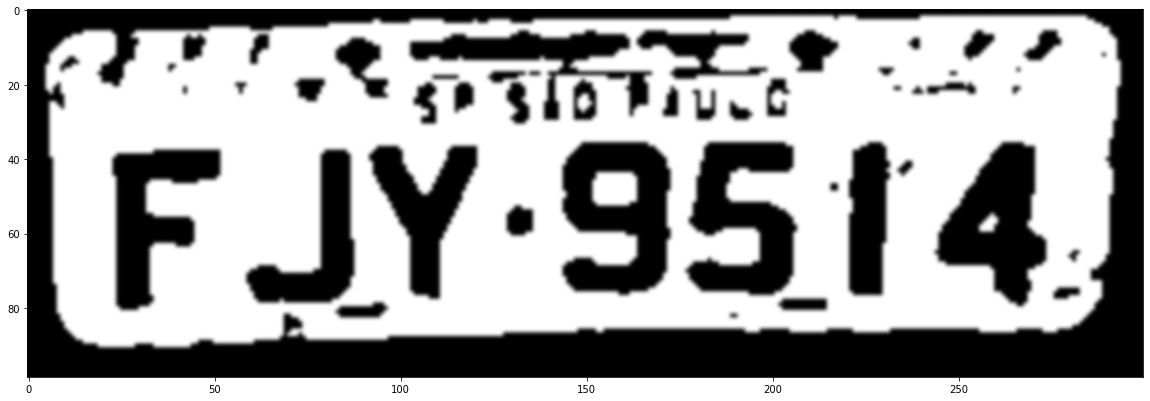

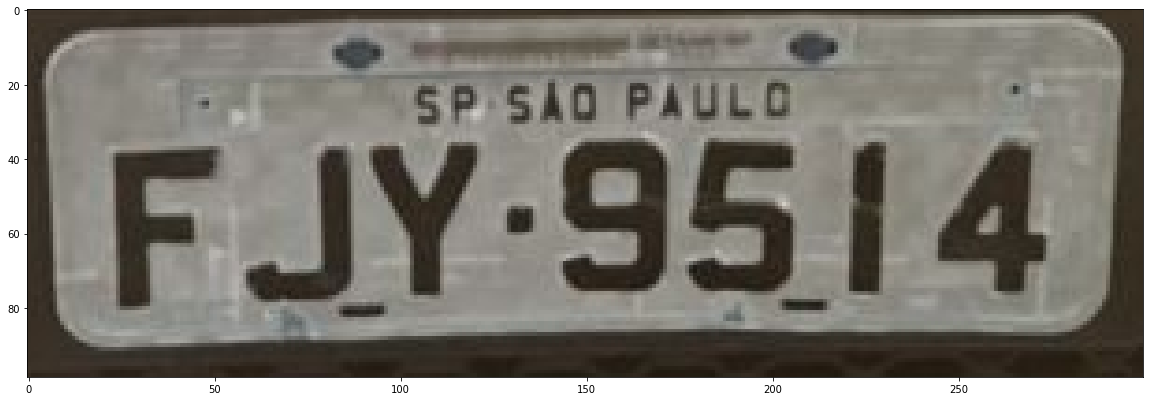

In [ ]:
imagem = cv2.imread('/content/plates_br/images/FJY-9514.jpg')
placas = detect(detector,  imagem)

## Exemplo de detecção por path

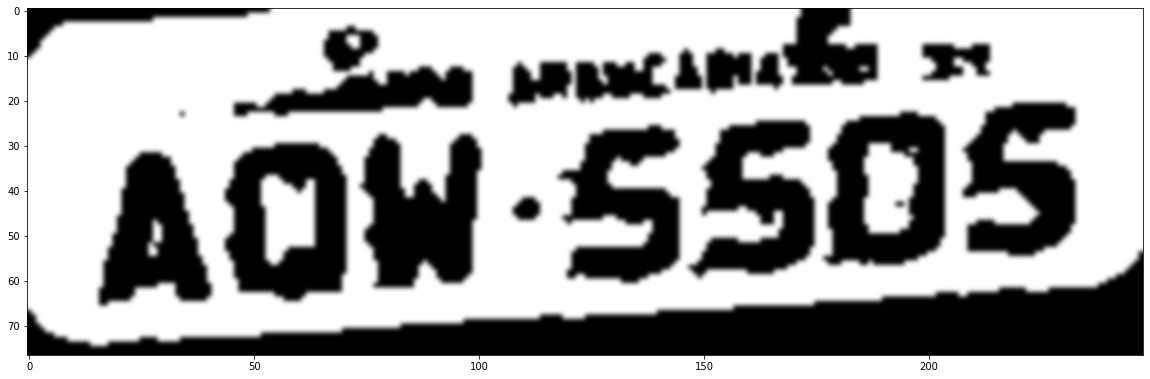

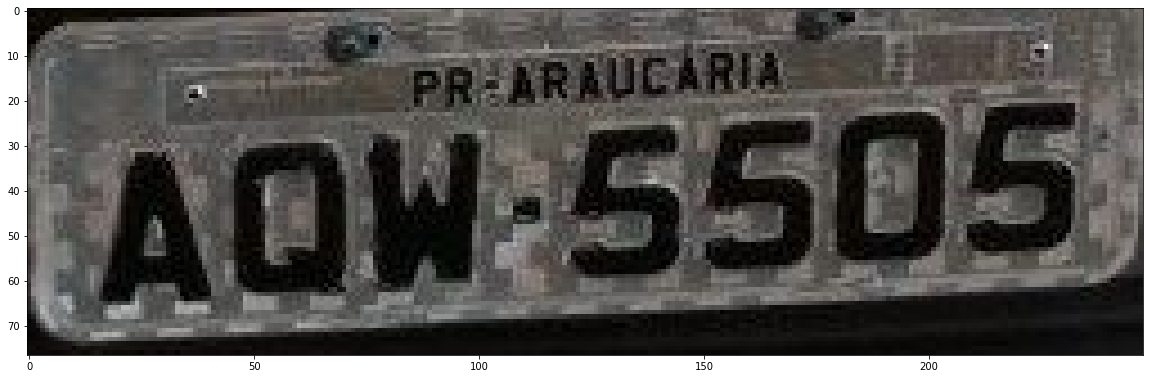

In [ ]:
placas = detect_by_path('/content/plates_br/images/AQW-5505.jpg')

## Exemplo de detecção por Link

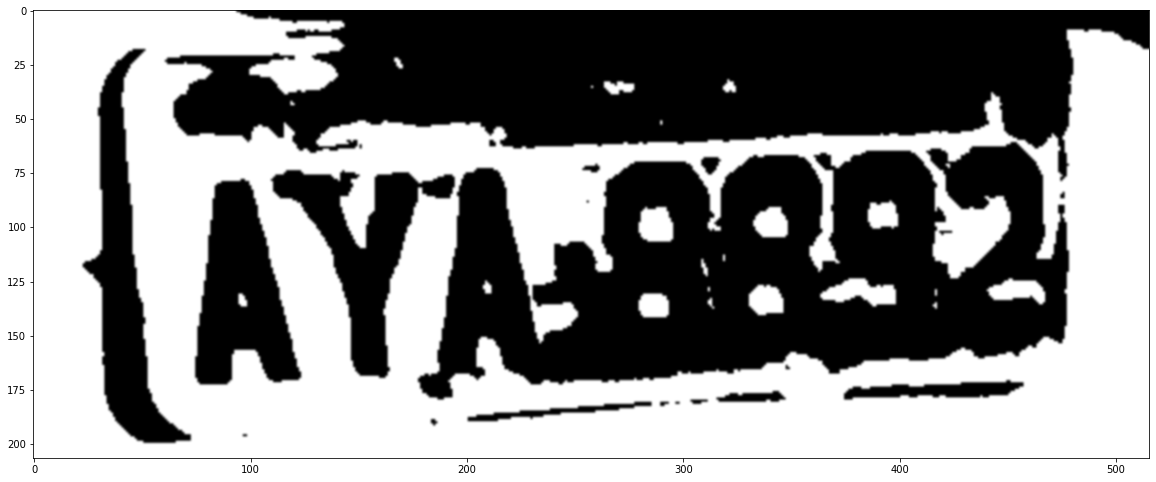

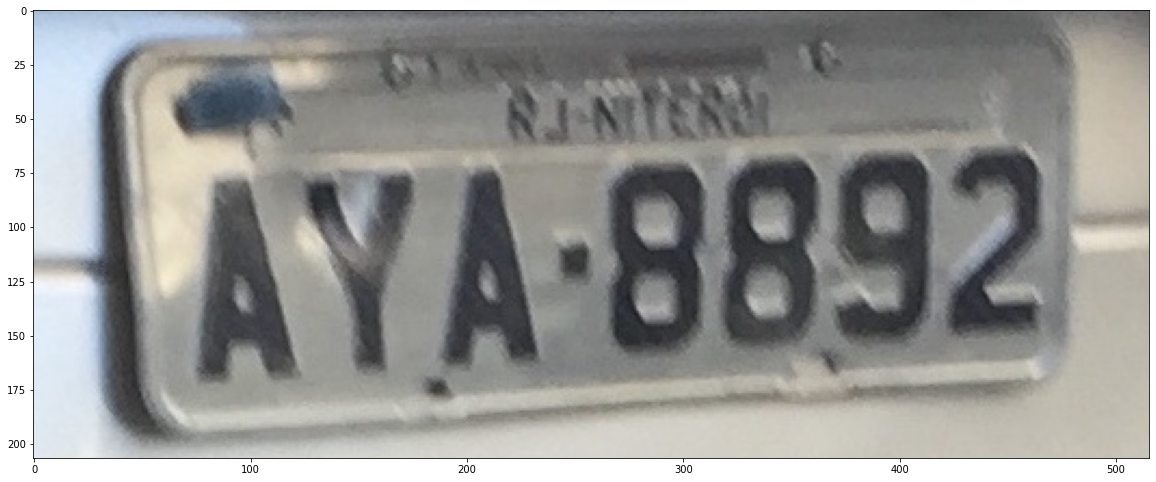

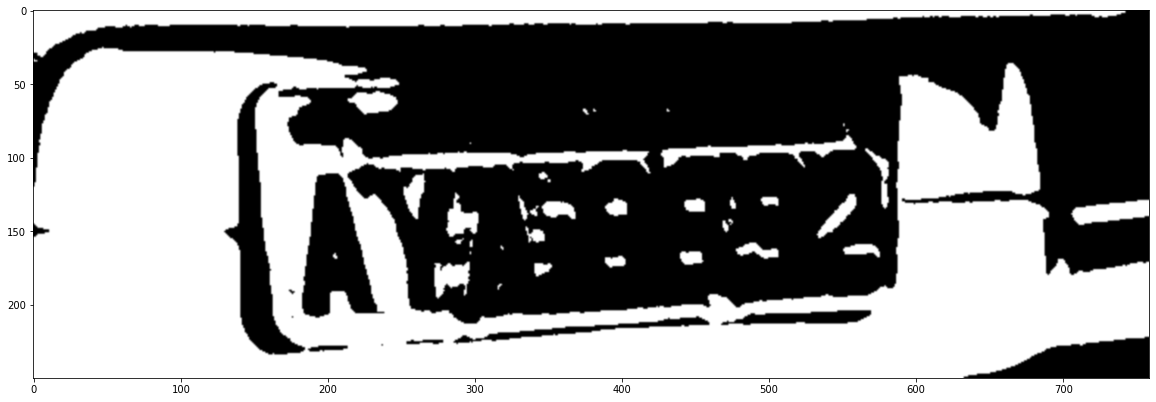

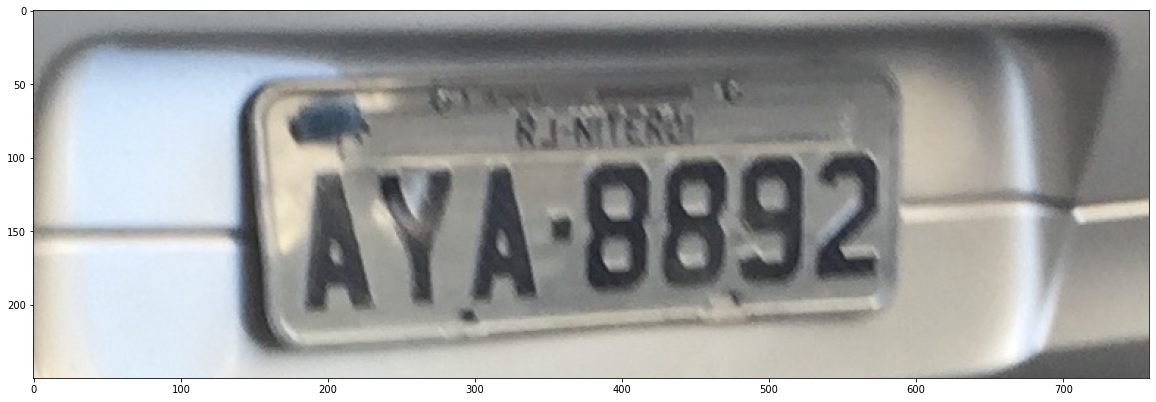

In [ ]:
placas = detect_by_link('https://raw.githubusercontent.com/openalpr/plates_br/master/images/AYA-8892.JPG')

In [ ]:
print(placas)

[' \n\x0c', ' \n\x0c']
